In [1]:
import os
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import gym
import numpy as np

from stable_baselines import DQN
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy


from stable_baselines.common.callbacks import CheckpointCallback

from ads_utils import load_data, plot, Environment, write_to_logs, plot_k_timesteps
from tqdm import tqdm

import time

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [25]:
EPOCHS = 100
INITIAL_BALANCE = 10_000
PAST_TICKS = 20

train_range = [i for i in range(24, 13-1, -1)]
train_data = load_data(train_range)

env_train = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

# separate instance
env_learn = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

val_range = [i for i in range(12, 7-1, -1)]
val_data = load_data(val_range)
env_val =  Environment(val_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

In [ ]:
start_time = time.time()

# model-fluent-sweep's parameters
model = DQN(MlpPolicy, env_learn, learning_rate=0.00001, batch_size=50, seed=1, verbose=0, double_q=True)
            #tensorboard_log="./DQN_tensorboard/")

train_portfolio_values = []
val_portfolio_values = []

for i in range(EPOCHS):
    
    # model learn already implicitly calls env.reset
    model.learn(total_timesteps=10_000)  
    
    train_obs = env_train.reset(rand_start=False) # t=0
    for j in range(len(train_data)-PAST_TICKS-1):
        # predict on training
        action, _ = model.predict(train_obs)
        
        _, train_portfolio_value = env_train.get_data()
     
        train_obs, _, done, _ = env_train.step(action)
        
        if done:
            break
    train_portfolio_values.append(train_portfolio_value)
    
    # predict on validation
    val_obs = env_val.reset(rand_start=False) # t=0
    for j in range(len(val_data)-PAST_TICKS-1):

        action, _ = model.predict(val_obs)
       
        _, val_portfolio_value = env_val.get_data()

        val_obs, _, done, _ = env_val.step(action)

        if done:
            break
            
    val_portfolio_values.append(val_portfolio_value)
#     if env_test.epoch_count >= EPOCHS:
#         break
    print(f'epoch number {i}')

print(time.time()-start_time)

epoch number 0
epoch number 1
epoch number 2
epoch number 3
epoch number 4
epoch number 5
epoch number 6
epoch number 7
epoch number 8


In [ ]:
epoch_ranges = np.arange(1, EPOCHS+1)
epoch_ranges

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))
plt.plot(epoch_ranges, train_portfolio_values, label="training")
plt.plot(epoch_ranges, val_portfolio_values, label="validation")
plt.title("Learning Curve", fontsize=22)
plt.xlabel("Episodes", fontsize=20)
plt.ylabel("Portfolio Value", fontsize=20)
plt.grid()
plt.legend(fontsize=16)
#plt.savefig("learning_curve_2")

In [14]:
write_to_logs(env_learn.logger, filename="learning_curve_1")
model.save("learning_curve_1")

In [4]:
# model learn timesteps(10_000 * EPOCHS)
# use callback to save model!
start_time = time.time()
env_learn = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS, train=True)
model = DQN(MlpPolicy, env_learn, learning_rate=0.00001, batch_size=50, seed=1, verbose=1, double_q=True)
checkpoint_callback = CheckpointCallback(save_freq=10_000, save_path='./checkpoint_logs/',
                                         name_prefix='DQN')

model.learn(10_000*100, callback=checkpoint_callback, log_interval=10_000)
print(time.time()-start_time)

3597.977014064789


In [5]:
start_time = time.time()
log_dir = "./checkpoint_logs/"
EPOCHS = 100

env_train = Environment(train_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

env_val =  Environment(val_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)


train_portfolio_values = []
val_portfolio_values = []

for i in range(1, EPOCHS + 1): 
    path = log_dir + f"DQN_{i*10000}_steps"
    print(path)
    model = DQN.load(path)
    
    train_obs = env_train.reset(rand_start=False) # t=0
    for j in range(len(train_data)-PAST_TICKS-1):
        # predict on training
        action, _ = model.predict(train_obs)
        
        _, train_portfolio_value = env_train.get_data()
     
        train_obs, _, done, _ = env_train.step(action)
        
        if done:
            break
    train_portfolio_values.append(train_portfolio_value)
    
    # predict on validation
    val_obs = env_val.reset(rand_start=False) # t=0
    for j in range(len(val_data)-PAST_TICKS-1):

        action, _ = model.predict(val_obs)
       
        _, val_portfolio_value = env_val.get_data()

        val_obs, _, done, _ = env_val.step(action)

        if done:
            break
            
    val_portfolio_values.append(val_portfolio_value)
    
print(time.time()-start_time)

./checkpoint_logs/DQN_10000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_20000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_30000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_40000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_50000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_60000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_70000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_80000_steps
Loading

./checkpoint_logs/DQN_610000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_620000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_630000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_640000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_650000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_660000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_670000_steps
Loading a model without an environment, this model cannot be trained until it has a valid environment.
./checkpoint_logs/DQN_680000_steps

In [6]:
epoch_ranges = np.arange(1, EPOCHS+1)

In [8]:
learn_df = pd.DataFrame(env_learn.logger, columns = ["epoch", "reward", "portfolio_value", "tc", "curr_step"])

In [16]:
learn_df[learn_df.epoch==2]

,epoch,reward,portfolio_value,tc,curr_step
4733,2,0.000000,10000.000000,0,77729
4734,2,-2.350210,9997.649790,1,77730
4735,2,-4.551420,9993.098370,2,77731
4736,2,1.040000,9994.138370,2,77732
4737,2,-1.850900,9992.287470,3,77733
...,...,...,...,...,...
9801,2,-0.813751,1826.006204,3358,82797
9802,2,-1.627120,1824.379084,3359,82798
9803,2,-0.129400,1824.249684,3359,82799
9804,2,-1.821869,1822.427815,3360,82800


In [10]:
train_df = pd.DataFrame(env_train.logger, columns = ["epoch", "reward", "portfolio_value", "tc", "curr_step"])

In [14]:
train_df[train_df.epoch==1]

,epoch,reward,portfolio_value,tc,curr_step
0,1,-3.2705,9996.7295,1,22
1,1,1.0000,9997.7295,1,23
2,1,0.2000,9997.9295,1,24
3,1,-2.7000,9995.2295,1,25
4,1,-1.4000,9993.8295,1,26
...,...,...,...,...,...
126002,1,0.1200,10028.8295,1,126024
126003,1,-0.9900,10027.8395,1,126025
126004,1,-0.5099,10027.3296,1,126026
126005,1,0.8299,10028.1595,1,126027


In [12]:
val_df = pd.DataFrame(env_val.logger, columns = ["epoch", "reward", "portfolio_value", "tc", "curr_step"])

In [13]:
val_df[val_df.epoch == 71]

,epoch,reward,portfolio_value,tc,curr_step
4246200,71,0.0,10000.000000,0,22
4246201,71,0.0,10000.000000,0,23
4246202,71,0.0,10000.000000,0,24
4246203,71,0.0,10000.000000,0,25
4246204,71,0.0,10000.000000,0,26
...,...,...,...,...,...
4306855,71,0.0,9993.242644,108,60677
4306856,71,0.0,9993.242644,108,60678
4306857,71,0.0,9993.242644,108,60679
4306858,71,0.0,9993.242644,108,60680


In [39]:
max_val = 0
index = 0
for i in range(1, len(val_portfolio_values)):
    if val_portfolio_values[i] > max_val:
        max_val = val_portfolio_values[i]
        index = i

In [41]:
val_portfolio_values[70]

10057.711176999996

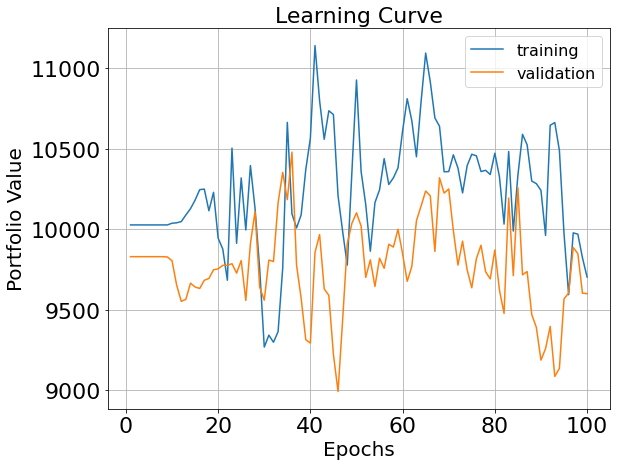

In [7]:
fig, ax = plt.subplots(figsize=(9,7))
plt.plot(epoch_ranges, train_portfolio_values, label="training")
plt.plot(epoch_ranges, val_portfolio_values, label="validation")
plt.title("Learning Curve", fontsize=22)
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Portfolio Value", fontsize=20)
plt.grid()
plt.legend(fontsize=16)
plt.savefig("learning_curve_double_qn_latest")

In [52]:
path = log_dir + f"DQN_{3*10000}_steps"
model_71 = DQN.load(path)

Loading a model without an environment, this model cannot be trained until it has a valid environment.


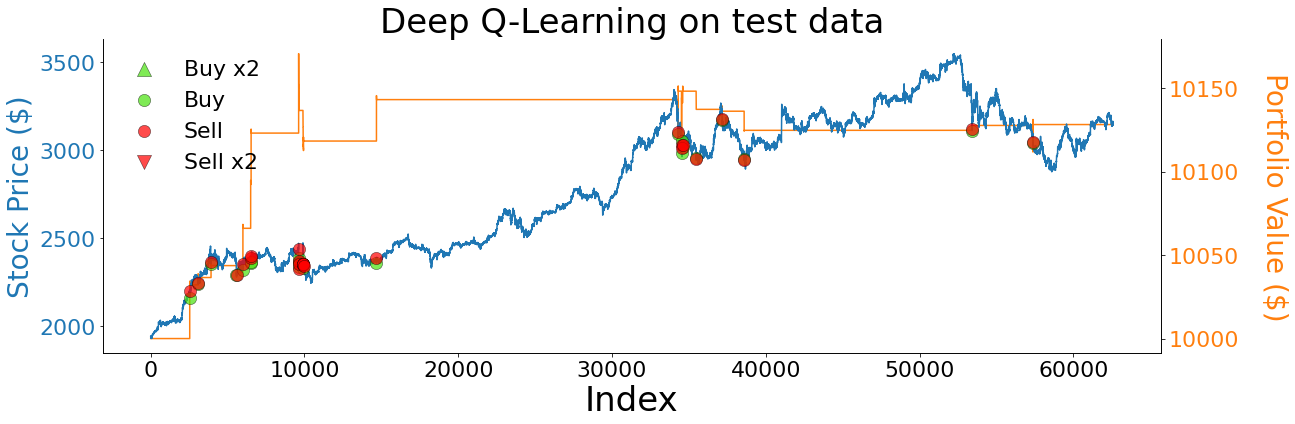

In [53]:
INITIAL_BALANCE = 10_000
PAST_TICKS = 20
SELL, HOLD, BUY = 0, 1, 2
test_range = [i for i in range(6, 1-1, -1)]
test_data = load_data(test_range)


env = Environment(test_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)

model = model_71

state = env.reset(rand_start=False)

portfolio_values = []
prices = []
actions = []

for i in range(len(test_data)):
    action, _ = model.predict(state)

    price, portfolio_value = env.get_data()
    
    actions.append(action)
    prices.append(price)
    
    portfolio_values.append(portfolio_value)

    state, reward, done, _ = env.step(action)
    
    if done:
        break
plot(prices, actions, portfolio_values, right_y_adjust=1.12, title="Deep Q-Learning on test data")

In [ ]:
plot(prices, actions, portfolio_values, right_y_adjust=1.12, title="Deep Q-Learning on test data")

In [46]:
train_logs = pd.read_csv("training_logs")

max_epoch = max(train_logs.epoch)
epoch_data = pd.DataFrame()
for i in range(1, max_epoch + 1):
    epoch_data = epoch_data.append(train_logs[train_logs.epoch==i][-1:])

Text(0, 0.5, 'final portfolio value')

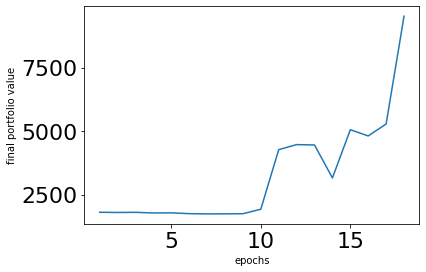

In [49]:
plt.plot(np.arange(1, max_epoch + 1), epoch_data.portfolio)
plt.xlabel("epochs")
plt.ylabel("final portfolio value")


In [50]:
val_logs = pd.read_csv("validation_logs")

max_epoch = max(val_logs.epoch)
epoch_val_data = pd.DataFrame()
for i in range(1, max_epoch + 1):
    epoch_val_data = epoch_val_data.append(val_logs[val_logs.epoch==i][-1:])

In [51]:
epoch_val_data

,epoch,reward,portfolio,cumulative_tc,curr_step
61159,1,-1.78275,9577.543576,57,61166


In [15]:
## save the model for my laptop's sake :P
model.save("deepq_firstrun")

In [14]:
len(data)

123933

In [12]:
len(val_data)

61167

hi!
hi!


/Users/graceong/Applied-Data-Science/ads_utils.py:323: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df = pd.read_csv(logs)


51.17675709724426


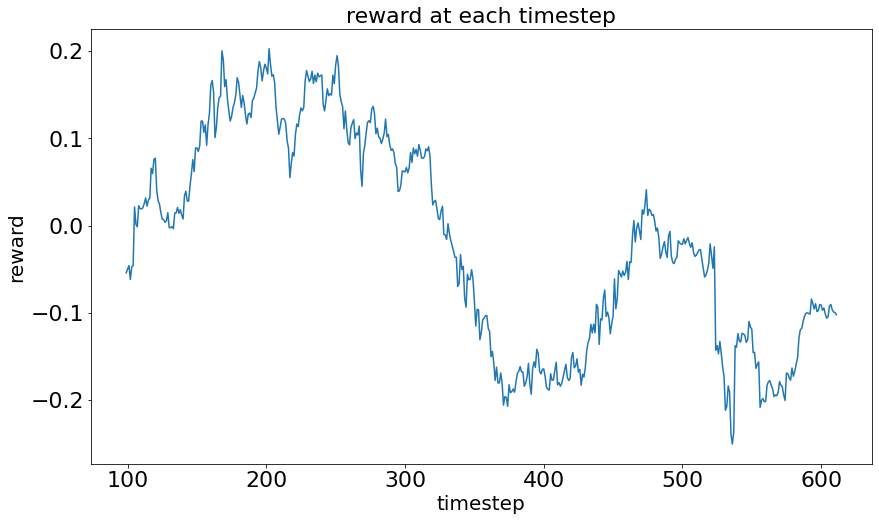

In [11]:
#validation 
start_time = time.time()
val_range = np.arange(13, 19)
val_data = load_data(val_range)
env_val = Environment(val_data["close"].to_list(), balance=INITIAL_BALANCE, past_ticks=PAST_TICKS)
state = env_val.reset()
portfolio_values = []
prices = []
actions = []
for i in range(len(val_data)-PAST_TICKS - 2):
    action, _ = model.predict(state)

    price, portfolio_value = env_val.get_data()
    actions.append(action)
    prices.append(price)
    portfolio_values.append(portfolio_value)

    state, reward, done, env_logs = env_val.step(action)

    if done:
        print("hi!")
        state = env.reset()

logs = env_logs["logs"]
write_to_logs(logs, filename="validation_logs")
plot_k_timesteps(logs="validation_logs")
print(time.time() - start_time)


/Users/graceong/Applied-Data-Science/ads_utils.py:323: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df = pd.read_csv(logs)


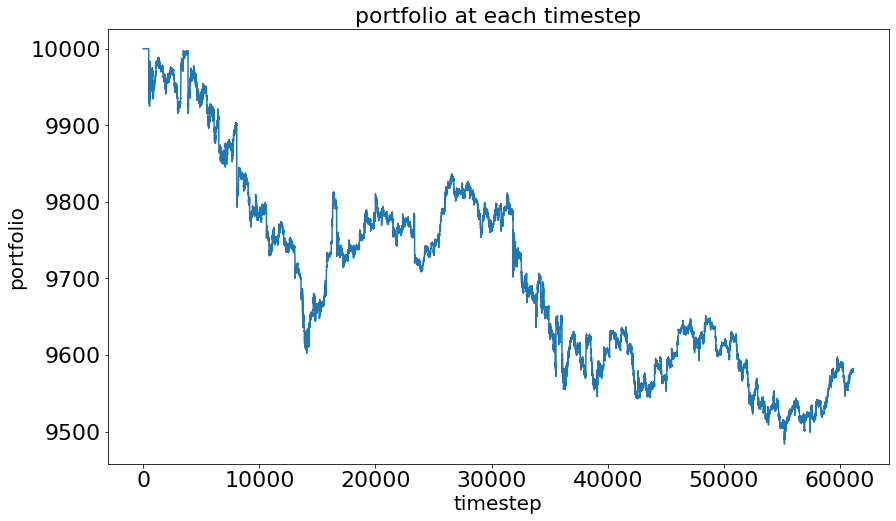

In [18]:
plot_k_timesteps(logs="validation_logs", k=1, window=1, y_col="portfolio")